### 1. Import Python module

In [153]:
import time
import os
import random
import seaborn as sn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision import models
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import KFold

torch.cuda.empty_cache()
seed = 24
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

num_workers = 4
batch_size = 16
categories = ['COVID19', 'NORMAL', 'PNEUMONIA']
num_classes = len(categories)
splits = ['train', 'test']
DATA_PATH = r"C:\Gunther\Datasets\Covid19DLH\Data"
model_path = r"C:\Gunther\OneDrive - University of Illinois - Urbana\Python\DLH\COVID-19-CHEST-X-RAY-IMAGE-CLASSISICATION"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'You are using {device}')

You are using cuda


### 2. Data pre-processing (Augmentation + DataLoader)

In [154]:
def show_dataset(data_path=DATA_PATH):
    df = pd.DataFrame(columns = ['code'] + splits, index = categories)
    for row in categories:
        for col in splits:
            df.loc[row,col] = int(len(os.listdir(os.path.join(data_path, col+'/'+row))))
    df['total'] = df.sum(axis=1).astype(int)
    df.loc['TOTAL'] = df.sum(axis=0).astype(int)
    df['code'] = ['0', '1', '2', '']
    print(df)
    return df

def load_data(data_path=DATA_PATH, num_workers=num_workers):
    transform_dict = {
        'model': transforms.Compose(
        [transforms.Resize(224),
         transforms.CenterCrop(224),
         transforms.ToTensor(),
         ])}
    train_data = datasets.ImageFolder(root=data_path + '/train', transform=transform_dict['model'])
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    test_data = datasets.ImageFolder(root=data_path + '/test', transform=transform_dict['model'])
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    return train_data, test_data, train_loader, test_loader

train_data, test_data, train_loader, test_loader = load_data()
dataset = torch.utils.data.ConcatDataset([train_data, test_data])
df_dataset = show_dataset()

          code train  test  total
COVID19      0   460   116    576
NORMAL       1  1266   317   1583
PNEUMONIA    2  3418   855   4273
TOTAL           5144  1288   6432


### 3. Explore processed image

Sample images for training purpose:
tensor([1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 2, 2, 1])


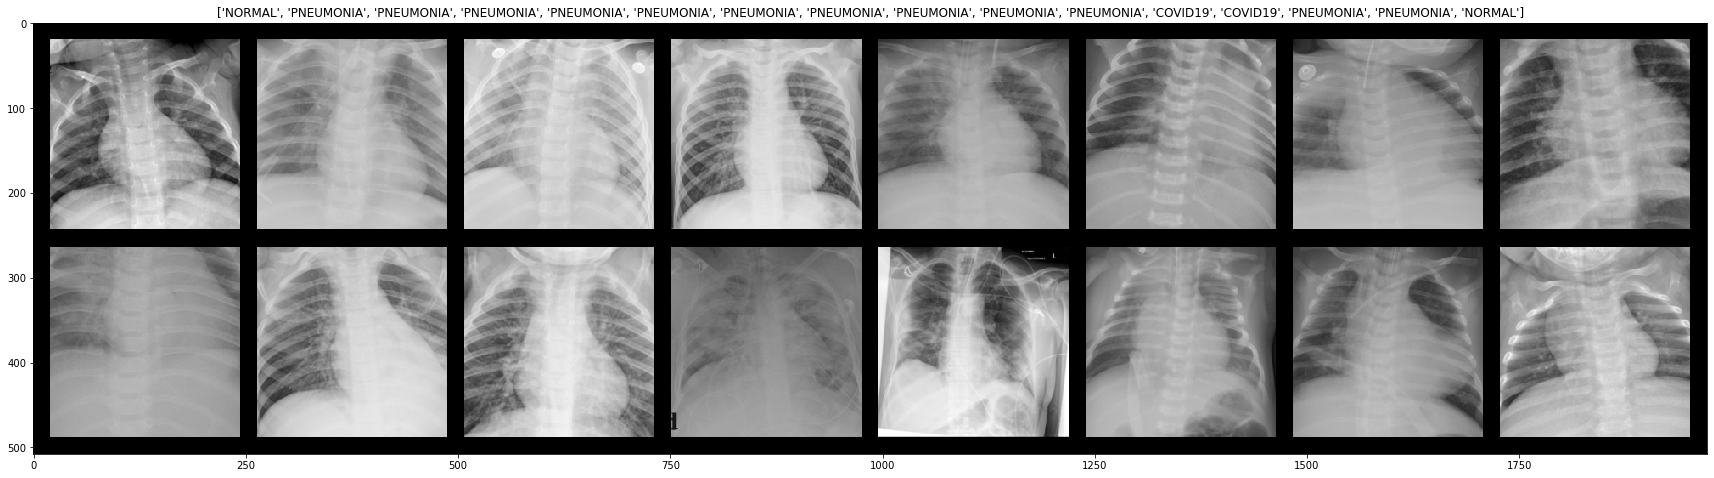

In [155]:
def show_batch_images(dataloader):
    images, labels = next(iter(dataloader))
    grid = torchvision.utils.make_grid(images, padding=20)
    print(labels)
    npgrid = grid.cpu().numpy()
    plt.figure(figsize=(30, 15))
    plt.imshow(np.transpose(npgrid, (1, 2, 0)), interpolation='nearest')
    plt.title(label=["COVID19" if x==0  else ("NORMAL" if x == 1 else "PNEUMONIA") for x in labels])
    plt.show()

print(f'Sample images for training purpose:')
for i in range(1):
    show_batch_images(train_loader)

### 3. Create the train, evaluate and test functions

In [156]:
def calc_metrics(predictions, actuals, row):
        df = pd.DataFrame(columns =['AUC', 'Precision', 'Recall', 'F1-score'])
        Y_pred = np.concatenate(predictions, axis=0)
        Y_test = np.concatenate(actuals, axis=0)
        df.loc[row, 'AUC', ] = accuracy_score(Y_test, Y_pred)
        df.loc[row, 'Precision', ] = precision_score(Y_test, Y_pred, average="macro")
        df.loc[row, 'Recall'] = recall_score(Y_test, Y_pred, average="macro")
        df.loc[row, 'F1-score'] = f1_score(Y_test, Y_pred, average="macro")
        return df

def calc_pred_actual(model, loader):
    model.eval()
    torch.manual_seed(seed)
    predictions, actuals = [], []
    for data, target in loader:
        data = data.to(device)
        target = target.to(device)
        Y_pred_orig = model(data)
        _, Y_pred_tag = torch.max(Y_pred_orig, dim = 1)
        Y_pred_tag = Y_pred_tag.detach().cpu().numpy()
        Y_pred_tag = Y_pred_tag.reshape(len(Y_pred_tag), 1)
        Y_test = target.cpu().numpy()
        Y_test = Y_test.reshape(len(Y_test), 1)
        predictions.append(Y_pred_tag)
        actuals.append(Y_test)
    return predictions, actuals

def create_confusion_matrix(preds, y_test):
    ylist, predlist = [], []
    for pred in preds:
        for item in pred:
            predlist.append(int(item))
    for y in y_test:
        for item in y:
            ylist.append(int(item))
    data_dict = {'y_Actual':    ylist, 'y_Predicted': predlist}
    df = pd.DataFrame(data_dict, columns=['y_Actual','y_Predicted'])
    cm = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['ACTUAL'], colnames=['PREDICTED'])
    return cm

def train_model(model):
    model.train()
    t0 = time.time()
    df = pd.DataFrame(columns = ['model_name', 'epoch', 'loss'])
    print(f"Training the model {model_name} with {df_dataset.loc['TOTAL', 'train']} samples and {n_epochs} epochs \n")
    for epoch in range(n_epochs):
        curr_epoch_loss = []
        for data, target in train_loader:
            target = target.to(device)
            data = data.to(device)
            outputs = model(data)
            loss = criterion(outputs, target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            curr_epoch_loss.append(loss.cpu().detach().numpy())
        print(f"Epoch {epoch}:\t loss={np.mean(curr_epoch_loss):.5f} \t time={(time.time() - t0):.2f}s")
        df.loc[len(df)] = [model_name, epoch, np.mean(curr_epoch_loss)]
    return model, df

def validate_model(model, k_folds = 5):
    print(f"Validating the model {model_name} with {df_dataset.loc['TOTAL', 'train']} samples and {k_folds}-folds \n")
    df = pd.DataFrame(columns =['AUC', 'Precision', 'Recall', 'F1-score'])
    kfold = KFold(n_splits=k_folds, shuffle=True)
    for fold, (train_ids, test_ids) in enumerate(kfold.split(train_data)):
        train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
        test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)
        train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, num_workers=num_workers, sampler=train_subsampler)
        test_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, num_workers=num_workers, sampler=test_subsampler)
        predictions, actuals = calc_pred_actual(model, train_loader)
        conf_matrix = create_confusion_matrix(predictions, actuals)
        df_aux = calc_metrics(predictions, actuals, 'FOLD '+str(fold+1))
        df = df.append(df_aux)
    df.loc['Average'] = df.mean(axis=0)
    print(df.astype(float))
    return df.astype(float), conf_matrix

def test_model(model):
    print(f"Testing the model {model_name} with {df_dataset.loc['TOTAL', 'test']} samples \n")
    predictions, actuals = calc_pred_actual(model, test_loader)
    conf_matrix = create_confusion_matrix(predictions, actuals)
    df_test = calc_metrics(predictions, actuals, 'Test Results').astype(float)
    print(df_test)
    return df_test, conf_matrix

def plot_epoch(df):
    _ = plt.plot(df['epoch'], df['loss'])
    plt.xlabel('Epoch') 
    plt.ylabel('Loss')
    _ = plt.title(label=f"Training loss vs epoch for model: {df.iloc[0,0]}", fontsize=15, color="darkblue")
    plt.show()

### 4. Build our own model

#### 4.1 Architecture of our own model

In [157]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = torch.nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn1 = torch.nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.relu = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=4, stride=4)
        self.conv2 = torch.nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn2 = torch.nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.linear1 = nn.Linear(28 * 28 * 32, 128)
        self.dropout = nn.Dropout(p=0.5)
        self.linear2 = nn.Linear(128, 3)
    def forward(self, x):
        x = self.pool1(self.relu(self.bn1(self.conv1(x))))
        x = self.pool2(self.relu(self.bn2(self.conv2(x))))
        x = x.reshape(x.size(0), -1)
        x = self.relu(self.linear1(x))
        x = self.dropout(x)
        x = self.linear2(x)
        return x

#### 4.2 Define parameters of our own model

In [7]:
model_CNN = Net().to(device)
model_name = 'DLH_team'
n_epochs = 20
learning_rate = 1e-2
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_CNN.parameters(), lr=learning_rate)

#### 4.3 Train our own model and save

In [10]:
our_model, df_epochs = train_model(model_CNN)
torch.save(our_model.state_dict(), os.path.join(model_path, 'our_ownmodel.pth'))

Training the model DLH_team with 5144 samples and 20 epochs 

Epoch 0:	 loss=0.41844 	 time=44.05s
Epoch 1:	 loss=0.26090 	 time=114.80s
Epoch 2:	 loss=0.22387 	 time=216.55s
Epoch 3:	 loss=0.19936 	 time=376.96s
Epoch 4:	 loss=0.18078 	 time=548.23s
Epoch 5:	 loss=0.17050 	 time=699.44s
Epoch 6:	 loss=0.16202 	 time=778.48s
Epoch 7:	 loss=0.13960 	 time=836.69s
Epoch 8:	 loss=0.14681 	 time=892.90s
Epoch 9:	 loss=0.13548 	 time=960.08s
Epoch 10:	 loss=0.13067 	 time=1025.55s
Epoch 11:	 loss=0.13354 	 time=1087.25s
Epoch 12:	 loss=0.10986 	 time=1147.08s
Epoch 13:	 loss=0.10918 	 time=1205.67s
Epoch 14:	 loss=0.10161 	 time=1262.18s
Epoch 15:	 loss=0.09217 	 time=1321.33s
Epoch 16:	 loss=0.08919 	 time=1379.65s
Epoch 17:	 loss=0.09320 	 time=1438.55s
Epoch 18:	 loss=0.07891 	 time=1496.30s
Epoch 19:	 loss=0.07739 	 time=1561.69s


#### 4.4 Plot epoch loss of our own model

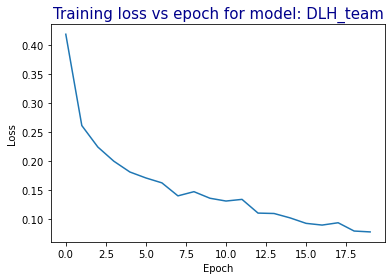

In [13]:
plot_epoch(df_epochs)

#### 4.5 Validate our own model

In [161]:
validation_results, conf_matrix_val = validate_model(our_model, k_folds = 5)

Validating the model DLH_team with 5144 samples and 5-folds 

              AUC  Precision    Recall  F1-score
FOLD 1   0.972539   0.986332  0.961044  0.972577
FOLD 2   0.971324   0.984854  0.960051  0.971268
FOLD 3   0.969866   0.984227  0.957821  0.969697
FOLD 4   0.971810   0.985100  0.960431  0.971605
FOLD 5   0.972546   0.985931  0.960855  0.972258
Average  0.971617   0.985289  0.960041  0.971481


#### 4.6 Show confusion matrix for validation dataset

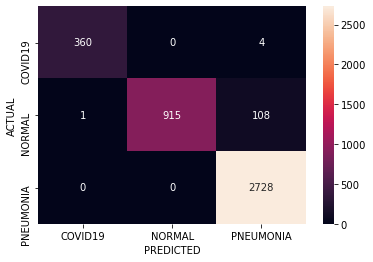

In [164]:
_ = sn.heatmap(conf_matrix_val, annot=True, fmt='g', xticklabels=categories, yticklabels=categories)

#### 4.7 Test our own model

In [165]:
test_results, conf_matrix_test = test_model(our_model)

Testing the model DLH_team with 1288 samples 

                  AUC  Precision    Recall  F1-score
Test Results  0.95264   0.963902  0.924253  0.942706


#### 4.8 Show confusion matrix for test dataset

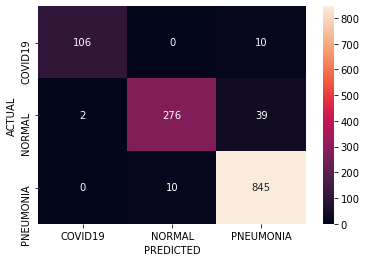

In [167]:
_ = sn.heatmap(conf_matrix_test, annot=True, fmt='g', xticklabels=categories, yticklabels=categories)

#### 4.9 (Optional) load a model already saved

In [160]:
model_name = 'DLH_team'
our_model = Net().to(device)  
our_model.load_state_dict(torch.load(os.path.join(model_path, 'our_ownmodel.pth')))  
_ = our_model.eval()

### 5. Create a model from a pre-trained one

#### 5.1 Select the pre-trained model

In [24]:
n_epochs = 10
learning_rate = 1e-2
model_name = 'Resnet18'
pre_trained_model = torchvision.models.resnet18(pretrained=True)

for param in pre_trained_model.parameters():
    param.requires_grad = False
num_ftrs = pre_trained_model.fc.in_features        
pre_trained_model.fc = nn.Linear(num_ftrs, num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(pre_trained_model.fc.parameters(), lr= learning_rate)  

#### 5.2 Train the pre-trained model and save

In [25]:
new_model, df_epochs2 = train_model(pre_trained_model.to(device))
torch.save(new_model.state_dict(), os.path.join(model_path, 'pretrained.pth'))

Training the model Resnet18 with 5144 samples and 10 epochs 

Epoch 0:	 loss=0.38788 	 time=51.82s
Epoch 1:	 loss=0.26353 	 time=105.78s
Epoch 2:	 loss=0.24427 	 time=158.95s
Epoch 3:	 loss=0.20863 	 time=214.07s
Epoch 4:	 loss=0.20855 	 time=268.49s
Epoch 5:	 loss=0.19957 	 time=321.49s
Epoch 6:	 loss=0.20883 	 time=378.00s
Epoch 7:	 loss=0.19740 	 time=432.37s
Epoch 8:	 loss=0.18775 	 time=497.08s
Epoch 9:	 loss=0.18376 	 time=553.20s


#### 5.3 Plot epoch loss of the pre-trained model

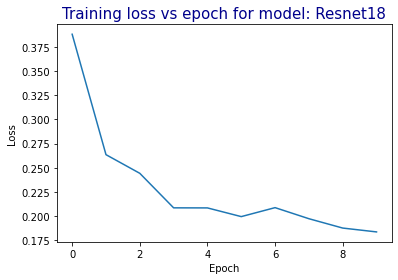

In [26]:
plot_epoch(df_epochs2)

#### 5.3 Validate the pre-trained model

In [27]:
validation_results, conf_matrix_test2 = validate_model(new_model, k_folds = 5)

Validating the model Resnet18 with 5144 samples and 5-folds 

              AUC  Precision    Recall  F1-score
FOLD 1   0.954313   0.957975  0.939580  0.948415
FOLD 2   0.949696   0.953246  0.933266  0.942668
FOLD 3   0.947509   0.951948  0.930121  0.940247
FOLD 4   0.949696   0.954990  0.935117  0.944357
FOLD 5   0.950923   0.956980  0.933190  0.944293
Average  0.950428   0.955028  0.934255  0.943996


#### 5.4 Test the pre-trained model and save

In [28]:
test_results, conf_matrix_test2 = test_model(new_model)

Testing the model Resnet18 with 1288 samples 

                  AUC  Precision    Recall  F1-score
Test Results  0.93323   0.944319  0.883379  0.910834
